<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">EfficintNetV2 Study</span>

In [1]:
import itertools
import os
import random
import gc
import numpy as np
import pandas as pd
import math
import pprint
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={"axes.titlesize":15, "axes.labelsize":9,"axes.titlepad":15,
            "axes.labelpad":12, "legend.fontsize":9,
            "legend.title_fontsize":9, "figure.titlesize":15,
            "axes.grid":False})

from sklearn.model_selection import train_test_split, GroupKFold
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets

print('TF version:', tf.__version__)
print('Hub version:', tfhub.__version__)
print('Physical devices:', tf.config.list_physical_devices())

TF version: 2.4.1
Hub version: 0.12.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Loaders & Augmentations on TPU</span>

Thanks to [@cdeotte](https://www.kaggle.com/cdeotte) & [@xhlulu](https://www.kaggle.com/xhlulu)

In [2]:
SATURATION  = (0.9, 1.1)
CONTRAST = (0.9, 1.1)
BRIGHTNESS  =  0.1
ROTATION    = 10.0
SHEAR    = 2.0
HZOOM  = 8.0
WZOOM  = 4.0
HSHIFT = 4.0
WSHIFT = 4.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg.input_dims[0]
    XDIM = DIM%2
    
    rot = ROTATION * tf.random.normal([1], dtype='float32')
    shr = SHEAR * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM
    h_shift = HSHIFT * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT * tf.random.normal([1], dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [3]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy


def build_decoder(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, SATURATION[0], SATURATION[1])
        img = tf.image.random_contrast(img, CONTRAST[0], CONTRAST[1])
        img = tf.image.random_brightness(img, BRIGHTNESS)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,
                  seed=None, cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    
    # Map the functions to perform Augmentations
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.map(transform, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle, seed=seed) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Global Config & Seeding</span>

In [4]:
def seed_everything(SEED):
    os.environ['PYTHONHASHSEED']=str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)

In [5]:
class Config:
    seed = 333
    job = 1
    num_classes = 4
    input_dims =(512,512)# (768, 768) 
    model_arch = "efficientnetv2-l-21k-ft1k" ## Choose model architecture
    batch_size = 8*16
    kfold = 5
    n_epochs = 15
    lr = 0.001
    loss_func = 'categorical_crossentropy'
    # Whether to finetune the whole model or just the top layer.
    fine_tune = True
    wandb_project = 'SIIM_classifier_public'
    dataset = "siim-covid19-images-metadata-256-512-768"
    
    seed_everything(seed)
    
cfg = Config()

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">KFold Split</span>

In [6]:
# df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
df = pd.read_csv('../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_meta_512x512.csv')
#df = pd.read_csv('../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_meta_768x768.csv')
study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
study_df = study_df.rename({'id':'study_id'}, axis=1)
df['study_id'] = df['study_id']+ '_study'
df = pd.merge(df, study_df, on = 'study_id', how = 'left')

label_cols = ['Negative for Pneumonia','Typical Appearance',
            'Indeterminate Appearance','Atypical Appearance']

gkf  = GroupKFold(n_splits=cfg.kfold)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=df.study_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
    
df.to_csv('study_train_df.csv')
df.sample(3)

,id,folder_id,study_id,width,height,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,fold
4348,34b56732e1b2_image,cc0d7eb2ea8c,36d6d8418099_study,2220,2277,1,0,0,0,4
5505,364e2b97c131_image,8896c9291fc9,d0906bce2ac6_study,3000,2228,0,1,0,0,3
2076,70248cd9577f_image,6edba3a25a28,accb3f0a6276_study,2832,2320,0,0,1,0,4


<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🚀 Training</span>

We first find the GCS path of the selected EffNetV2 architecture from the EffNetV2 weights Kaggle dataset.

In [7]:
# Get the TensorFlow Hub model URL
hub_type = 'feature_vector' # ['classification', 'feature_vector']
# Get the GCS path of EfficientNet Models
DS_GCS_PATH = KaggleDatasets().get_gcs_path("efficientnetv2-tfhub-weight-files")
MODEL_GCS_PATH = f'{DS_GCS_PATH}/tfhub_models/{cfg.model_arch}/{hub_type}'
MODEL_GCS_PATH

'gs://kds-c4de05380d5dff17668f745c8db63b869ed18757abfc3795e2c2ac84/tfhub_models/efficientnetv2-l-21k-ft1k/feature_vector'

In [8]:
#import wandb
#from kaggle_secrets import UserSecretsClient

#user_secrets = UserSecretsClient()
#wandb_api = user_secrets.get_secret("wandb_key") 
#wandb.login(key=wandb_api)


Fold: 0
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold0_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 0,
 'input_dims': '(512, 512)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold0_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}
Epoch 1/15
39/39 [==============================] - 264s 4s/step - loss: 1.1305 - accuracy: 0.5442 - auc: 0.6241 - val_loss: 1.1856 - val_accuracy: 0.5983 - val_auc: 0.7224
Epoch 2/15
39/39 [==============================] - 15s 380ms/step - loss: 0.9738 - accuracy: 0.6226 - auc: 0.7420 - val_loss: 0.9159 - val_accuracy: 0.6354 - val_auc: 0.7776
Epoch 3/15
39/39 [==============================] - 16s 416ms/step - loss: 0.9362 - accuracy: 0.6377 - auc: 0.7632 -

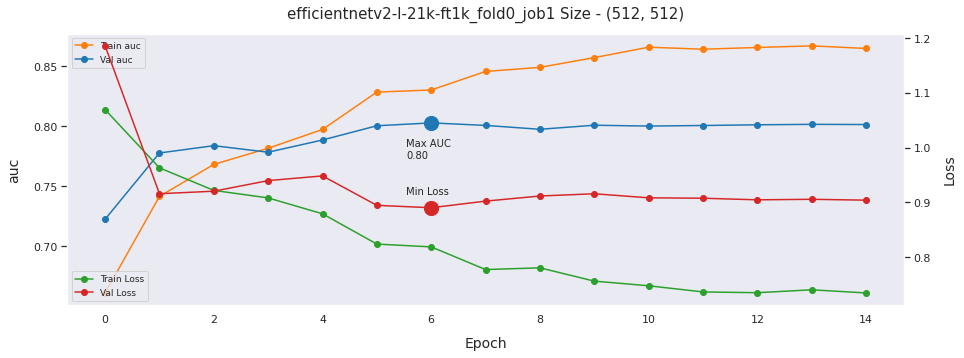


Fold: 1
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold1_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 1,
 'input_dims': '(512, 512)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold1_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}
Epoch 1/15
39/39 [==============================] - 200s 3s/step - loss: 1.1515 - accuracy: 0.5156 - auc: 0.6270 - val_loss: 0.9785 - val_accuracy: 0.6448 - val_auc: 0.7493
Epoch 2/15
39/39 [==============================] - 16s 400ms/step - loss: 1.0173 - accuracy: 0.5976 - auc: 0.7183 - val_loss: 0.9527 - val_accuracy: 0.6369 - val_auc: 0.7658
Epoch 3/15
39/39 [==============================] - 17s 428ms/step - loss: 0.9520 - accuracy: 0.6229 - auc: 0.7563 -

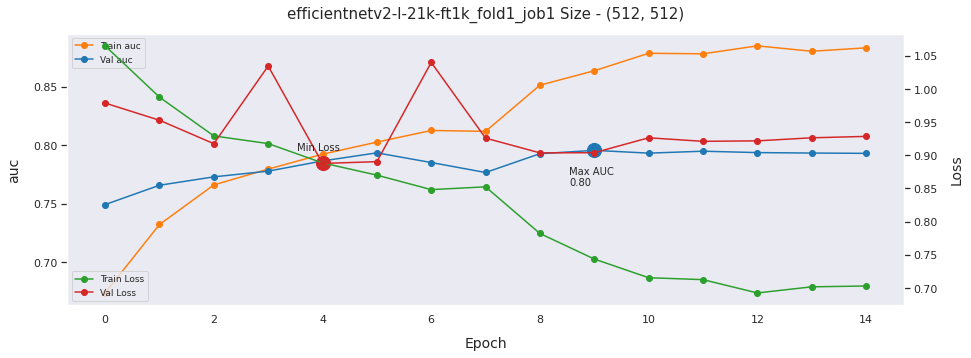


Fold: 2
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold2_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 2,
 'input_dims': '(512, 512)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold2_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}
Epoch 1/15
39/39 [==============================] - 195s 3s/step - loss: 1.1254 - accuracy: 0.5368 - auc: 0.6376 - val_loss: 1.0823 - val_accuracy: 0.6172 - val_auc: 0.7137
Epoch 2/15
39/39 [==============================] - 14s 361ms/step - loss: 0.9982 - accuracy: 0.6177 - auc: 0.7224 - val_loss: 1.0719 - val_accuracy: 0.6164 - val_auc: 0.7291
Epoch 3/15
39/39 [==============================] - 16s 398ms/step - loss: 0.9446 - accuracy: 0.6448 - auc: 0.7573 -

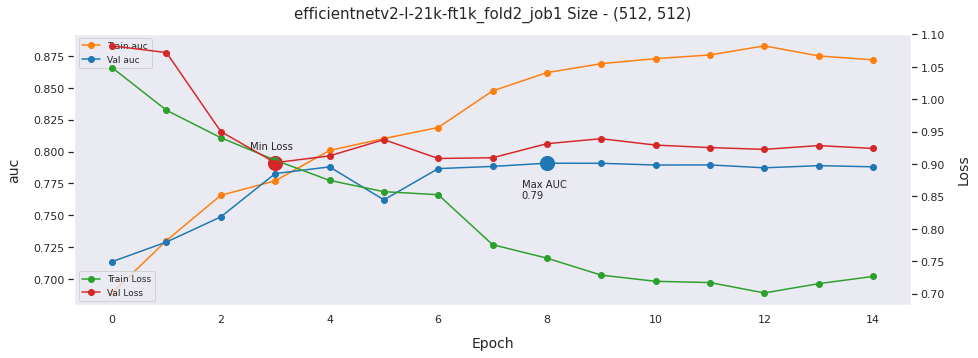


Fold: 3
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold3_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 3,
 'input_dims': '(512, 512)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold3_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}
Epoch 1/15
39/39 [==============================] - 200s 3s/step - loss: 1.1271 - accuracy: 0.5401 - auc: 0.6468 - val_loss: 1.1838 - val_accuracy: 0.5556 - val_auc: 0.6961
Epoch 2/15
39/39 [==============================] - 16s 410ms/step - loss: 0.9564 - accuracy: 0.6326 - auc: 0.7422 - val_loss: 0.9366 - val_accuracy: 0.6496 - val_auc: 0.7686
Epoch 3/15
39/39 [==============================] - 17s 439ms/step - loss: 0.9617 - accuracy: 0.6243 - auc: 0.7561 -

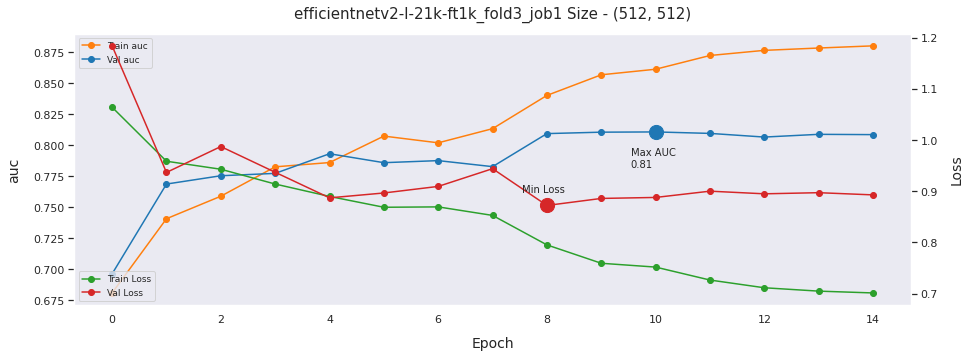


Fold: 4
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold4_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 4,
 'input_dims': '(512, 512)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold4_job1',
 'kfold': 5,
 'loss_func': 'categorical_crossentropy',
 'lr': '0.001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 15,
 'num_classes': 4,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}
Epoch 1/15
39/39 [==============================] - 211s 3s/step - loss: 1.1289 - accuracy: 0.5455 - auc: 0.6369 - val_loss: 0.9968 - val_accuracy: 0.6074 - val_auc: 0.7694
Epoch 2/15
39/39 [==============================] - 16s 413ms/step - loss: 0.9807 - accuracy: 0.6206 - auc: 0.7413 - val_loss: 0.9387 - val_accuracy: 0.6414 - val_auc: 0.7666
Epoch 3/15
39/39 [==============================] - 17s 426ms/step - loss: 0.9306 - accuracy: 0.6334 - auc: 0.7610 -

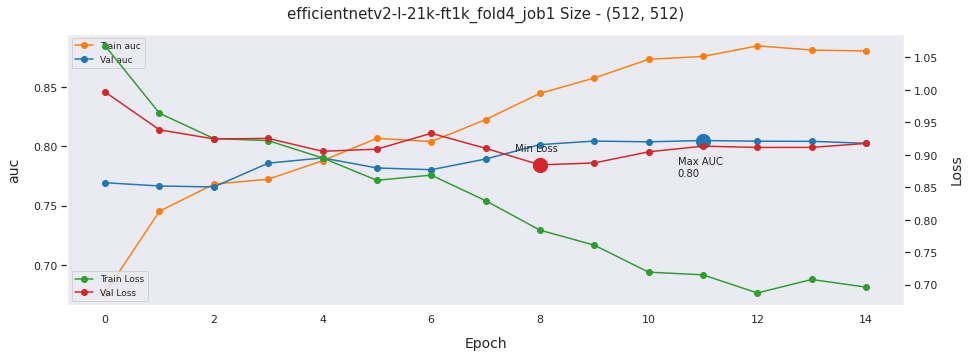


----------------------------------------
CV AUC: 0.8009759902954101
----------------------------------------


In [9]:
DISPLAY_PLOT = True
oof_aucs = dict()
ImageSizePath = ['768x768','512x512','256x256']

# Get the GCS path of the images from the Kaggle dataset
GCS_DS_PATH = KaggleDatasets().get_gcs_path(cfg.dataset)

for fold in range(cfg.kfold):
    
    print("\nFold:", fold)
    
    # Define TPU strategy and clear TPU
    strategy = auto_select_accelerator()
    
    # Converting global config class object to a dictionary to log using Wandb
    config_dict = dict(vars(Config))
    config_dict = {k:(v if type(v)==int else str(v)) for (k,v) in config_dict.items() if '__' not in k}
    config_dict['fold'] = fold
    config_dict['job_name'] = f"{config_dict['model_arch']}_fold{fold}_job{config_dict['job']}"
    print("Train Job:", config_dict['job_name'], "\nConfig")
    pprint.pprint(config_dict)

    #wandb.init(project=cfg.wandb_project, name=config_dict['job_name'], config=config_dict)

    valid_paths = GCS_DS_PATH + f'/images_metadata_256_512_768/train_{ImageSizePath[1]}/' + df[df['fold']==fold]['id'] + '.png' #"/train/"
    train_paths = GCS_DS_PATH + f'/images_metadata_256_512_768/train_{ImageSizePath[1]}/' + df[df['fold']!=fold]['id'] + '.png' #"/train/" 
    valid_labels = df[df['fold']==fold][label_cols].values
    train_labels = df[df['fold']!=fold][label_cols].values

    decoder = build_decoder(with_labels=True, target_size=cfg.input_dims, ext='png')
    test_decoder = build_decoder(with_labels=False, target_size=cfg.input_dims, ext='png')

    train_dataset = build_dataset(
        train_paths, train_labels, bsize=cfg.batch_size, decode_fn=decoder
    )

    valid_dataset = build_dataset(
        valid_paths, valid_labels, bsize=cfg.batch_size, decode_fn=decoder,
        repeat=False, shuffle=False, augment=False
    )

    num_classes = cfg.num_classes if cfg.num_classes else train_labels.shape[1]

    with strategy.scope():
        model = tf.keras.Sequential([
            # Explicitly define the input shape so the model can be properly
            # loaded by the TFLiteConverter
            tf.keras.layers.InputLayer(input_shape=[cfg.input_dims[0], cfg.input_dims[1], 3]),
            tfhub.KerasLayer(MODEL_GCS_PATH, trainable=cfg.fine_tune),
            tf.keras.layers.Dropout(rate=0.1),
            tf.keras.layers.Dense(num_classes,
                                  activation='softmax')
        ])

        model.build((None, cfg.input_dims[0], cfg.input_dims[1], 3))
#         model.summary()

        metrics = ['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=True)]
        model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.lr),
          loss=cfg.loss_func,
          metrics=metrics)

    steps_per_epoch = train_paths.shape[0] // cfg.batch_size
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f'model{fold}.h5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min'),
        #wandb.keras.WandbCallback(save_model=True,
        #              monitor='val_loss',
        #              mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                             patience=3,
                                             min_lr=1e-6,
                                             mode='min'),
                ]

    history = model.fit(
        train_dataset, 
        epochs=cfg.n_epochs,
        verbose=1,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset)

    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history{fold}.csv')

    del decoder, test_decoder, train_dataset, valid_dataset, model
    gc.collect()

    oof_aucs[fold] = float(np.max(history.history['val_auc']))
    print("oof_aucs", oof_aucs)
    
    #wandb.finish()
    
    # Plot Training History
    if DISPLAY_PLOT:
        print ("\n\n")
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(history.history['auc'])), history.history['auc'],
                 '-o', label='Train auc', color='#ff7f0e')
        plt.plot(np.arange(len(history.history['auc'])), history.history['val_auc'],
                 '-o', label='Val auc', color='#1f77b4')
        x = np.argmax(history.history['val_auc'])
        y = np.max(history.history['val_auc'])
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200, color='#1f77b4')
        plt.text(x-0.03*xdist, y-0.13*ydist, 'Max AUC\n%.2f'%y, size=10)
        plt.ylabel('auc', size=14)
        plt.xlabel('Epoch', size=14)
        plt.legend(loc=2)

        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(len(history.history['auc'])),
                  history.history['loss'],'-o', label='Train Loss', color='#2ca02c')
        plt2.plot(np.arange(len(history.history['auc'])),
                  history.history['val_loss'],'-o', label='Val Loss', color='#d62728')
        x = np.argmin(history.history['val_loss'])
        y = np.min(history.history['val_loss'])
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x, y, s=200, color='#d62728')
        plt.text(x-0.03*xdist, y+0.05*ydist,'Min Loss', size=10)
        plt.ylabel('Loss', size=14)
        plt.title(f"{config_dict['job_name']} Size - {cfg.input_dims}")
        plt.legend(loc=3)
        plt.savefig(f'fig{fold}.png')
        plt.show()
        
print("\n"+"-"*40)
print("CV AUC:", sum(list(oof_aucs.values()))/cfg.kfold)
print("-"*40)

In [10]:
# !rm -r /kaggle/working/wandb